In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

train = pd.read_parquet('data/train/train_main_df.parquet')
target = pd.read_csv('data/info/train_target.csv')
test = pd.read_parquet('data/test/test_main_df.parquet')

train_main = pd.read_parquet('data/train/train_main_df.parquet')
target = pd.read_csv('data/info/train_target.csv')
mcc_features = ['sum_most_popular_mcc_5699_12m', 'sum_most_popular_mcc_5699_6m', 'sum_most_popular_mcc_6012_3m', 'sum_most_popular_mcc_6012_6m', 'sum_most_popular_mcc_5814_12m', 'sum_most_popular_mcc_5422_3m', 'cnt_most_popular_mcc_9222_6m', 'sum_most_popular_mcc_4814_6m', 'cnt_most_popular_mcc_9222_12m', 'sum_most_popular_mcc_5993_6m', 'cnt_most_popular_mcc_5422_3m', 'cnt_most_popular_mcc_5422_6m', 'sum_most_popular_mcc_5993_3m', 'cnt_most_popular_mcc_5814_1m', 'sum_most_popular_mcc_6011_3m']

train_mcc = pd.read_parquet('data/train/train_mcc_operations_df.parquet')

train = train_main.merge(
    train_mcc[mcc_features], 
    left_index=True, 
    right_index=True,  
    how='left'         
)

test_main = pd.read_parquet('data/test/test_main_df.parquet')

test_mcc = pd.read_parquet('data/test/test_mcc_operations_df.parquet')

test = test_main.merge(
    test_mcc[mcc_features], 
    left_index=True, 
    right_index=True,  
    how='left'         
)

In [2]:
notcool_features = [
    'income_verified',
    'zp_payments_1month',
    'zp_flag_12month', 
    'savings_safe_acc_flg', 
    'zp_flag_18month', 
    'zp_flag_24month', 
    'zp_flag_3month', 
    'zp_flag_6month', 
    'zp_flag_9month',
    
    'cnt_manage_5y',	
    'app_real_estate_ind',
    'cnt_account_5y',
    'app_vehicle_ind',

    'vehicle_counrty_type_nm',
    'max_amt_foreign_cur_5y',
    'max_amt_dep_6m',
    'min_amt_term_g1y',
    #new
    "zp_first_month", 
    "zp_mean_12month", 
    "zp_mean_24month", 
    "sum_amount_zp_12m"
]

In [3]:
cleaned_df = train.drop(columns=notcool_features)
len(cleaned_df.columns)

274

In [4]:
train['salary_flg'] = train['salary_flg'].replace('SZP', 1).replace('IZP', 0).replace('OTHER', 0).replace('', 0) 
train['gender_nm'] = train['gender_nm'].replace("Ж", 1).replace("М", 0).replace('?', 0.5)
train['current_work_experience_nm'] = train['current_work_experience_nm'].replace("", 3).replace("0-3м", 0).replace("3-6м", 1).replace("6-12м", 2).replace('12м+', 3)
train['savings_service_model_cd'] = train['savings_service_model_cd'].replace("Массовый", 0).replace("Привилегия", 1).replace("VIP", 2)
test['salary_flg'] = test['salary_flg'].replace('SZP', 1).replace('IZP', 0).replace('OTHER', 0).replace('', 0) 
test['gender_nm'] = test['gender_nm'].replace("Ж", 1).replace("М", 0).replace('?', 0.5)
test['current_work_experience_nm'] = test['current_work_experience_nm'].replace("", 3).replace("0-3м", 0).replace("3-6м", 1).replace("6-12м", 2).replace('12м+', 3)
test['savings_service_model_cd'] = test['savings_service_model_cd'].replace("Массовый", 0).replace("Привилегия", 1).replace("VIP", 2)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_4380\4013919353.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['salary_flg'] = train['salary_flg'].replace('SZP', 1).replace('IZP', 0).replace('OTHER', 0).replace('', 0)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_4380\4013919353.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['gender_nm'] = train['gender_nm'].replace("Ж", 1).replace("М", 0).replace('?', 0.5)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_4380\4013919353.py:3: FutureWarning: Downcas

In [5]:
def create_new_features(df):
    # 1. Средний баланс за последние 3, 6, 12 месяцев
    df['avg_balance_3m'] = df[['avg_dep_avg_balance_1month_amt', 
                               'avg_dep_avg_balance_3month_amt']].mean(axis=1)
    df['avg_balance_6m'] = df[['avg_dep_avg_balance_3month_amt', 
                               'avg_dep_avg_balance_6month_amt']].mean(axis=1)
    df['avg_balance_12m'] = df[['avg_dep_avg_balance_6month_amt', 
                                'avg_dep_avg_balance_12month_amt']].mean(axis=1)
    
    # 2. Изменение баланса за последние месяцы
    df['balance_change_1m'] = df['avg_dep_avg_balance_1month_amt'] - df['avg_dep_avg_balance_3month_amt']
    df['balance_change_3m'] = df['avg_dep_avg_balance_3month_amt'] - df['avg_dep_avg_balance_6month_amt']
    df['balance_change_6m'] = df['avg_dep_avg_balance_6month_amt'] - df['avg_dep_avg_balance_12month_amt']
    
    # 3. Тренды по сбережениям
    df['savings_trend_3m'] = df['savings_sum_dep_now'] - df['savings_sum_dep_3m']
    df['savings_trend_6m'] = df['savings_sum_dep_now'] - df['savings_sum_dep_6m']
    
    # 4. Флаги крупных операций
    df['large_deposit_flag'] = np.where(df['max_max_dep_income_amt'] > df['avg_dep_avg_balance_12month_amt'], 1, 0)
    
    return df
train = create_new_features(train)
test = create_new_features(test)

In [6]:
num_features = list(train.select_dtypes(include=['number']).columns.drop(notcool_features))
new_features = [
    'avg_balance_3m',
    'avg_balance_6m',
    'avg_balance_12m',
    'balance_change_1m',
    'balance_change_3m',
    'balance_change_6m',
    'savings_trend_3m',
    'savings_trend_6m',
    'large_deposit_flag',
]

num_features = list(set(num_features + new_features))

In [7]:
for col in num_features:
    q1 = train[col].quantile(0.01)
    q99 = train[col].quantile(0.99)
    train[col] = train[col].clip(q1, q99)
    test[col] = test[col].clip(q1, q99)

In [8]:
X_train = train[num_features]
y_train = np.log1p(target['target'])

estimators = [
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=120,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1)),
    ('cat', CatBoostRegressor(verbose=False))
]

model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model.fit(X_train, y_train)
test_predict = model.predict(test[num_features])
y_pred = np.expm1(test_predict)
y_pred = np.clip(y_pred, 0, None)
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train[num_features], target['target'], test_size=0.3, random_state=42, shuffle=False)

In [10]:
X_train = train[num_features]
y_train = np.log1p(target['target'])
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=120,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1
)
model.fit(X_train, y_train)
predictions = model.predict(X_valid[num_features])
y_pred = np.exp(predictions) - 1
#y_valid = np.exp(y_valid) - 1

rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
print(f'RMSLE: {rmsle}')

# RMSLE: X_train = train[num_features]
y_train = np.log1p(target['target'])
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=120,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1
)
model.fit(X_train, y_train)
predictions = model.predict(X_valid[num_features])
y_pred = np.exp(predictions) - 1
#y_valid = np.exp(y_valid) - 1

rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
print(f'RMSLE: {rmsle}')

# RMSLE: 1.8566541480862322

RMSLE: 1.8551160852004454
RMSLE: 1.8551160852004454


In [11]:
estimators = [
    ('xgb', xgb.XGBRegressor(max_depth=5, learning_rate=0.01)),
    ('cat', CatBoostRegressor(verbose=False))
]

model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model.fit(X_train, y_train)
predictions = model.predict(X_valid[num_features])
y_pred = np.exp(predictions) - 1
#y_valid = np.exp(y_valid) - 1

rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
print(f'RMSLE: {rmsle}')

RMSLE: 1.7902815620279646


In [13]:
sorted_features = sorted(zip(X_train.columns, model.final_estimator_.coef_), 
                       key=lambda x: x[1], 
                       reverse=True)

for feature, importance in sorted_features:
    if importance < 0.001:
        print(f'"{feature}", ')

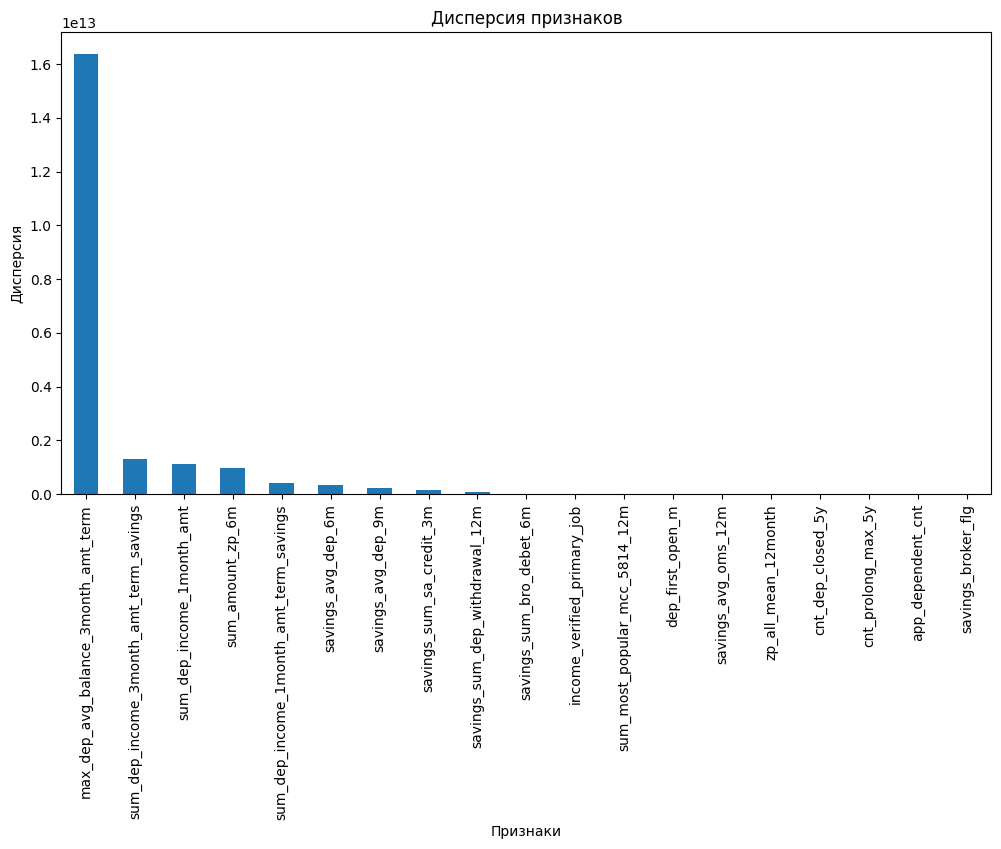

In [15]:
variances = X_train.var()[1:20]
sorted_variances = variances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_variances.plot(kind='bar')
plt.title('Дисперсия признаков')
plt.xlabel('Признаки')
plt.ylabel('Дисперсия')
plt.show()

In [16]:
# Вычисляем дисперсию признаков
variances = X_train.var()
high_variance_features = variances[variances > 0.95]
low_variance_features = variances[variances < 0.01]

print("Признаки с дисперсией больше 0.95:")
print(high_variance_features)
print("\nПризнаки с дисперсией меньше 0.01:")
print(low_variance_features)


Признаки с дисперсией больше 0.95:
avg_balance_3m                                 2.677457e+12
sum_most_popular_mcc_5814_12m                  2.462633e+09
max_dep_avg_balance_3month_amt_term            1.636351e+13
savings_sum_bro_debet_6m                       2.111220e+10
sum_dep_income_1month_amt                      1.133494e+12
                                                   ...     
savings_sum_dep_12m                            1.288292e+10
avg_balance_6m                                 2.579266e+12
zp_region_mean_6month                          5.213931e+00
avg_dep_avg_balance_6month_amt_term_savings    2.502696e+12
savings_sum_sa_debet_3m                        1.301956e+11
Length: 251, dtype: float64

Признаки с дисперсией меньше 0.01:
zp_flag_2month     0.0
used_car_flg       0.0
savings_oms_flg    0.0
dtype: float64
